In [1]:
#load in data

#define ROI

#define events  - select only emotional / neutral epochs

#define time - window: Other research uses around 100 - 400 ms

#calculate complex tfr using mortlet

#extract phase (theta, alpha)

#extract amplitude (gamma)

#create circular shift (zero lag)

#calculate Phase-Amplitude Coupling

#Statistical tests


In [1]:

import mne
import os, os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings

from mne.time_frequency import tfr_array_morlet
from scipy.stats import ttest_rel


In [2]:
#variables

epoch_dir = "/work/Reka_Clara/data/ds005107/derivatives/epochs"

subjects = ['01','02','03','04','05','06','07','08','09',
            '10','11','12','13','14','15','16','17','18','19',
            '20','21','22','23']

sessions = ['01','02']

runs     = ['01','02','03','04','05','06','07','08','09','10']

roi = ['MEG02','MEG29','MEG11','MEG47','MEG62','MEG15','MEG13','MEG10','MEG14',
       'MEG25','MEG48','MEG56','MEG61','MEG64','MEG52','MEG59','MEG12','MEG26', 'MEG49', 'MEG50', 'MEG39', 'MEG54', 'MEG23', 'MEG28']


In [3]:
all_ch_sets = []

for subject in subjects:
    subj_chs = []
    for session in sessions:
        for run in runs:
            fname = op.join(
                epoch_dir,
                f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-epo.fif"
            )
            if not op.exists(fname):
                continue

            ep = mne.read_epochs(fname, preload=False, verbose=False)

            # subtract bads before constructing channel set
            good_chs = set(ep.ch_names) - set(ep.info["bads"])

            subj_chs.append(good_chs)
            del ep

    if subj_chs:
        # intersection of good channels across ALL runs of that subject
        all_ch_sets.append(set.intersection(*subj_chs))


# intersection across all subjects
roi_global = set.intersection(*all_ch_sets)


roi_final = sorted(list(roi_global.intersection(roi)))

print(f"Total: {len(roi_final)} channels")

roi = roi_final

Total: 11 channels


In [6]:

def _complex_tfr_band(epochs, band, n_cycles_factor=2.0):
    data = epochs.get_data()  # (n_epochs, n_channels, n_times)
    sfreq = epochs.info['sfreq']

    freqs = np.arange(band[0], band[1] + 1)
    n_cycles = freqs / n_cycles_factor

    tfr = tfr_array_morlet(
        data,
        sfreq=sfreq,
        freqs=freqs,
        n_cycles=n_cycles,
        output='complex',
        use_fft=True,
        decim=1,
        n_jobs=-1,
    )
    # tfr shape: (n_epochs, n_chans, n_freqs, n_times)

    # average over FREQUENCIES (axis=2), keep channels
    tfr_band = tfr.mean(axis=2)  # -> (n_epochs, n_chans, n_times)

    return tfr_band, epochs.times

def _pac_mvl(phase, amp):
    # phase, amp: (n_epochs, n_channels, n_times)
    z = amp * np.exp(1j * phase)
    pac = np.abs(z.mean(axis=(0, 2)))  # (n_channels,)
    return pac


def _pac_surrogates(phase, amp, n_surrogates=200, random_state=0):
    rng = np.random.RandomState(random_state)
    n_epochs, n_channels, n_times = amp.shape
    surrogates = np.zeros((n_surrogates, n_channels))

    for s in range(n_surrogates):
        amp_shift = np.empty_like(amp)
        for ei in range(n_epochs):
            shift = rng.randint(0, n_times)
            amp_shift[ei] = np.roll(amp[ei], shift=shift, axis=-1)
        z = amp_shift * np.exp(1j * phase)
        surrogates[s] = np.abs(z.mean(axis=(0, 2)))
    return surrogates


def compute_pac_bandpair(
    epochs,
    low_band, high_band,
    tmin=0.1, tmax=0.4,
    n_surrogates=200,
):
    # epochs already contains ROI channels only

    low_cmplx, times = _complex_tfr_band(epochs, low_band)
    high_cmplx, _    = _complex_tfr_band(epochs, high_band)

    # 100–400 ms window
    tmask = (times >= tmin) & (times <= tmax)
    low_cmplx = low_cmplx[..., tmask]
    high_cmplx = high_cmplx[..., tmask]

    phase = np.angle(low_cmplx)
    amp   = np.abs(high_cmplx)

    # z-score amplitude per epoch/channel
    amp = (amp - amp.mean(axis=-1, keepdims=True)) / amp.std(axis=-1, keepdims=True)

    pac = _pac_mvl(phase, amp)
    surr = _pac_surrogates(phase, amp, n_surrogates=n_surrogates)

    pvals = (np.sum(surr >= pac[None, :], axis=0) + 1) / (n_surrogates + 1)

    surr_mean = surr.mean(axis=0)
    surr_std  = surr.std(axis=0, ddof=1)
    zscores   = (pac - surr_mean) / surr_std

    return pac, pvals, zscores

In [7]:
alpha_gamma_pac_e = []
alpha_gamma_pac_n = []
theta_gamma_pac_e = []
theta_gamma_pac_n = []

subjects_used = []
group_counts = []

for subject in subjects:
    eps_raw = []

    for session in sessions:
        for run in runs:
            fname = op.join(
                epoch_dir,
                f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-epo.fif"
            )
            if not op.exists(fname):
                continue

            ep = mne.read_epochs(fname, preload=True)
            if ep.metadata is None or 'emotion' not in ep.metadata.columns:
                continue

            eps_raw.append(ep)

    if not eps_raw:
        continue

    # ---- 1) Compute intersection of GOOD channels for this subject ----
    good_sets = []
    for ep in eps_raw:
        good = set(ep.ch_names) - set(ep.info['bads'])
        good_sets.append(good)

    subj_good = set.intersection(*good_sets)

    # restrict to your posterior ROI
    subj_roi = sorted(subj_good.intersection(roi))
    if len(subj_roi) == 0:
        continue  # subject has no usable ROI channels

    # ---- 2) Make per-run copies with identical channels and no bads ----
    eps_clean = []
    for ep in eps_raw:
        ep_c = ep.copy().pick_channels(subj_roi, ordered=True)
        ep_c.info['bads'] = []  # harmonize bads
        eps_clean.append(ep_c)

    # ---- 3) Now concatenation is safe ----
    epochs = mne.concatenate_epochs(eps_clean)

    # sanity check: all runs now have same channels
    assert len(epochs.ch_names) == len(subj_roi)

    # ---- 4) Proceed with metadata and conditions ----
    md = epochs.metadata

    counts = md['emotion'].value_counts().sort_index()
    group_counts.append(pd.Series(counts, name=f"sub-{subject}"))

    e_mask = md['emotion'] == 2
    n_mask = md['emotion'] == 1

    ep_e = epochs[e_mask]
    ep_n = epochs[n_mask]

    ep_e = ep_e.copy().pick_channels(subj_roi, ordered=True)
    ep_n = ep_n.copy().pick_channels(subj_roi, ordered=True)


    # ---- 5) PAC computations; epochs already contain ROI only ----
    pac_ag_e, p_ag_e, z_ag_e = compute_pac_bandpair(
        ep_e, low_band=(8, 12), high_band=(30, 40),
        tmin=0.1, tmax=0.4, n_surrogates=200
    )
    pac_ag_n, p_ag_n, z_ag_n = compute_pac_bandpair(
        ep_n, low_band=(8, 12), high_band=(30, 40),
        tmin=0.1, tmax=0.4, n_surrogates=200
    )

    pac_tg_e, p_tg_e, z_tg_e = compute_pac_bandpair(
        ep_e, low_band=(4, 7), high_band=(30, 40),
        tmin=0.1, tmax=0.4, n_surrogates=200
    )
    pac_tg_n, p_tg_n, z_tg_n = compute_pac_bandpair(
        ep_n, low_band=(4, 7), high_band=(30, 40),
        tmin=0.1, tmax=0.4, n_surrogates=200
    )

    alpha_gamma_pac_e.append(pac_ag_e)
    alpha_gamma_pac_n.append(pac_ag_n)
    theta_gamma_pac_e.append(pac_tg_e)
    theta_gamma_pac_n.append(pac_tg_n)

    subjects_used.append(subject)

    gc.collect()

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-01_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-01_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-01_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


5030 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    5.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   13.5s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    5.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   13.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-02_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
256 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-02_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
254 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-02_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-03_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
256 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-03_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
251 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-03_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   11.9s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   13.2s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-04_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-04_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
256 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-04_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
254 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-06_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
249 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-06_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-06_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    5.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.4s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    5.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.4s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-07_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-07_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
249 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-07_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
248 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-08_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-08_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-08_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
251 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-09_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-09_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-09_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
251 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.1s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-10_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
249 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-10_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-10_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    1.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    3.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    1.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    3.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-11_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-11_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-11_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
249 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    3.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    7.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    7.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-13_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
247 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-13_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-13_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
248 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    8.7s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.1s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-14_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-14_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
248 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-14_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
247 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    5.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   12.6s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    5.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   12.4s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-15_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
255 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-15_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-15_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-16_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
251 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-16_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-16_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
251 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-17_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-17_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
249 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-17_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   11.0s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.1s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-18_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
254 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-18_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
255 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-18_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-19_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
248 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-19_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
249 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-19_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
250 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.2s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.8s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-20_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-20_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
254 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-20_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.4s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.8s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-21_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-21_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
247 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-21_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.8s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   10.4s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-22_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-22_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
254 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-22_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-23_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
255 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-23_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-23_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
251 ma

/tmp/ipykernel_3050/2663771154.py:51: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps_clean)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    8.7s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    9.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [8]:
alpha_gamma_pac_e = np.vstack(alpha_gamma_pac_e)  # (n_subjects, n_channels)
alpha_gamma_pac_n = np.vstack(alpha_gamma_pac_n)
theta_gamma_pac_e = np.vstack(theta_gamma_pac_e)
theta_gamma_pac_n = np.vstack(theta_gamma_pac_n)

In [9]:
# collapse across channels
ag_e_mean = alpha_gamma_pac_e.mean(axis=1)  # (n_subjects,)
ag_n_mean = alpha_gamma_pac_n.mean(axis=1)
tg_e_mean = theta_gamma_pac_e.mean(axis=1)
tg_n_mean = theta_gamma_pac_n.mean(axis=1)

# paired t-tests emotion vs neutral
t_ag, p_ag = ttest_rel(ag_e_mean, ag_n_mean, nan_policy='omit')
t_tg, p_tg = ttest_rel(tg_e_mean, tg_n_mean, nan_policy='omit')

print("Alpha-gamma PAC (100–400 ms, posterior ROI) emotion vs neutral:")
print(f"t = {t_ag:.3f}, p = {p_ag:.3g}")

print("Theta-gamma PAC (100–400 ms, posterior ROI) emotion vs neutral:")
print(f"t = {t_tg:.3f}, p = {p_tg:.3g}")

Alpha-gamma PAC (100–400 ms, posterior ROI) emotion vs neutral:
t = -0.782, p = 0.443
Theta-gamma PAC (100–400 ms, posterior ROI) emotion vs neutral:
t = 0.049, p = 0.962


In [10]:
df = pd.DataFrame({
    "subject": subjects_used,
    "alpha_gamma_emotion": ag_e_mean,
    "alpha_gamma_neutral": ag_n_mean,
    "theta_gamma_emotion": tg_e_mean,
    "theta_gamma_neutral": tg_n_mean,
})

df["alpha_gamma_diff"] = df.alpha_gamma_emotion - df.alpha_gamma_neutral
df["theta_gamma_diff"] = df.theta_gamma_emotion - df.theta_gamma_neutral

df.to_csv("pac_results_final.csv", index=False)
print(df.head())

  subject  alpha_gamma_emotion  alpha_gamma_neutral  theta_gamma_emotion  \
0      01             0.008386             0.009683             0.023286   
1      02             0.008880             0.010155             0.012675   
2      03             0.006375             0.005067             0.012586   
3      04             0.005856             0.005598             0.007560   
4      06             0.006074             0.004319             0.009100   

   theta_gamma_neutral  alpha_gamma_diff  theta_gamma_diff  
0             0.022413         -0.001297          0.000873  
1             0.011818         -0.001275          0.000857  
2             0.012502          0.001308          0.000084  
3             0.009614          0.000257         -0.002054  
4             0.008967          0.001755          0.000133  


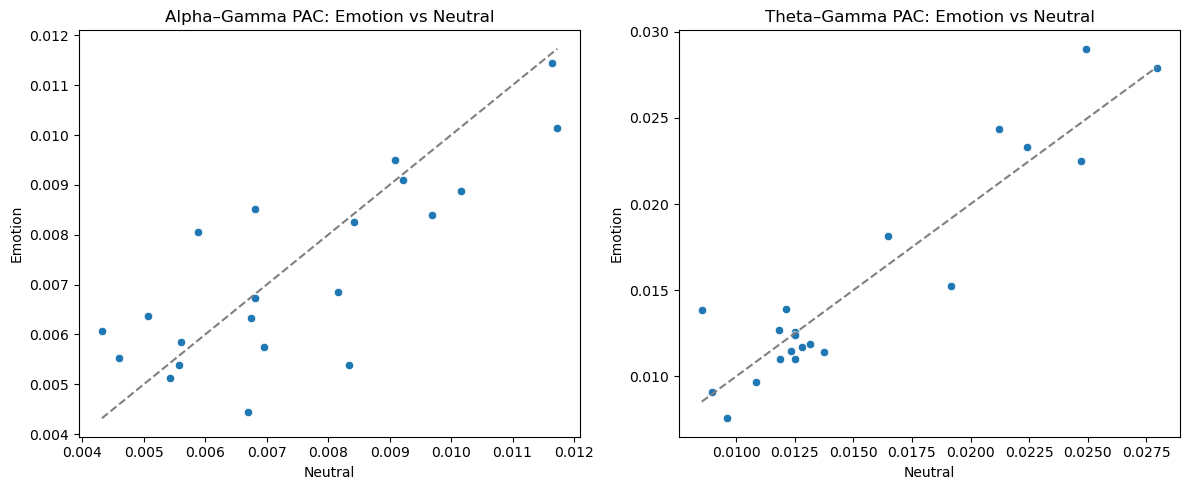

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------- Paired plots (emotion vs neutral) --------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# alpha–gamma
sns.scatterplot(
    x=df.alpha_gamma_neutral, 
    y=df.alpha_gamma_emotion,
    ax=ax[0]
)
ax[0].plot([df.alpha_gamma_neutral.min(), df.alpha_gamma_neutral.max()],
           [df.alpha_gamma_neutral.min(), df.alpha_gamma_neutral.max()],
           '--', color='gray')
ax[0].set_title("Alpha–Gamma PAC: Emotion vs Neutral")
ax[0].set_xlabel("Neutral")
ax[0].set_ylabel("Emotion")

# theta–gamma
sns.scatterplot(
    x=df.theta_gamma_neutral, 
    y=df.theta_gamma_emotion,
    ax=ax[1]
)
ax[1].plot([df.theta_gamma_neutral.min(), df.theta_gamma_neutral.max()],
           [df.theta_gamma_neutral.min(), df.theta_gamma_neutral.max()],
           '--', color='gray')
ax[1].set_title("Theta–Gamma PAC: Emotion vs Neutral")
ax[1].set_xlabel("Neutral")
ax[1].set_ylabel("Emotion")

plt.tight_layout()
plt.show()

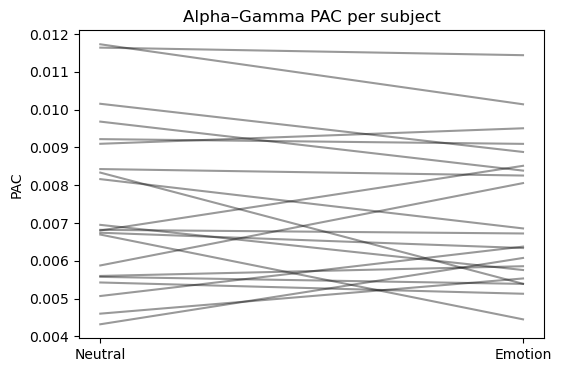

In [12]:
plt.figure(figsize=(6,4))
for _, row in df.iterrows():
    plt.plot(["Neutral","Emotion"],
             [row.alpha_gamma_neutral, row.alpha_gamma_emotion],
             color='black', alpha=0.4)
plt.title("Alpha–Gamma PAC per subject")
plt.ylabel("PAC")
plt.show()


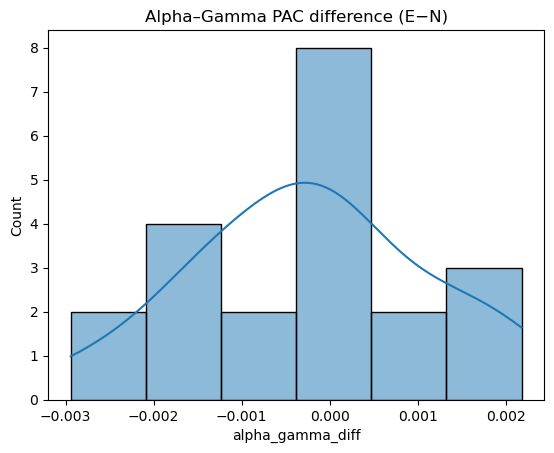

In [13]:
sns.histplot(df.alpha_gamma_diff, kde=True)
plt.title("Alpha–Gamma PAC difference (E−N)")
plt.show()

In [18]:
#load in dataframe

# Flatten PAC values from all subjects and channels into 1D_arr
all_pac = np.concatenate(alpha_gamma_pac_e + alpha_gamma_pac_n)

# Create a surrogate distribution (shuffle)
rng = np.random.RandomState(0)
surr = rng.permutation(all_pac)

surr_mean = surr.mean()
surr_std = surr.std()


z_ag_e = []
z_ag_n = []

for pac_arr in alpha_gamma_pac_e:
    z_ag_e.append((pac_arr.mean() - surr_mean) / surr_std)

for pac_arr in alpha_gamma_pac_n:
    z_ag_n.append((pac_arr.mean() - surr_mean) / surr_std)


z_tg_e = []
z_tg_n = []

for pac_arr in theta_gamma_pac_e:
    z_tg_e.append((pac_arr.mean() - surr_mean) / surr_std)

for pac_arr in theta_gamma_pac_n:
    z_tg_n.append((pac_arr.mean() - surr_mean) / surr_std)


In [19]:
df = pd.DataFrame({
    "subject": subjects_used,

    "ag_emotion": [x.mean() for x in alpha_gamma_pac_e],
    "ag_neutral": [x.mean() for x in alpha_gamma_pac_n],
    "tg_emotion": [x.mean() for x in theta_gamma_pac_e],
    "tg_neutral": [x.mean() for x in theta_gamma_pac_n],

    "z_ag_emotion": z_ag_e,
    "z_ag_neutral": z_ag_n,
    "z_tg_emotion": z_tg_e,
    "z_tg_neutral": z_tg_n,
})

In [20]:
df.head()


,subject,ag_emotion,ag_neutral,tg_emotion,tg_neutral,z_ag_emotion,z_ag_neutral,z_tg_emotion,z_tg_neutral
0,01,0.008386,0.009683,0.023286,0.022413,-0.832624,-0.662080,1.127060,1.012299
1,02,0.008880,0.010155,0.012675,0.011818,-0.767700,-0.600006,-0.268452,-0.381192
2,03,0.006375,0.005067,0.012586,0.012502,-1.097123,-1.269101,-0.280168,-0.291204
3,04,0.005856,0.005598,0.007560,0.009614,-1.165433,-1.199255,-0.941194,-0.671046
4,06,0.006074,0.004319,0.009100,0.008967,-1.136665,-1.367472,-0.738723,-0.756253


In [21]:
df["ag_diff"] = df.ag_emotion - df.ag_neutral
df["tg_diff"] = df.tg_emotion - df.tg_neutral


In [22]:
from scipy.stats import ttest_rel

t_ag, p_ag = ttest_rel(df.ag_emotion, df.ag_neutral)
t_tg, p_tg = ttest_rel(df.tg_emotion, df.tg_neutral)

print(f"Alpha–Gamma PAC: t = {t_ag:.3f}, p = {p_ag:.4f}")
print(f"Theta–Gamma PAC: t = {t_tg:.3f}, p = {p_tg:.4f}")

Alpha–Gamma PAC: t = -0.782, p = 0.4433
Theta–Gamma PAC: t = 0.049, p = 0.9615


In [23]:
from scipy.stats import ttest_1samp

def ztest(label, arr):
    t, p = ttest_1samp(arr, 0)
    print(f"{label}: mean z = {arr.mean():.3f}, t = {t:.3f}, p = {p:.4f}")

ztest("AG Emotion", df.z_ag_emotion)
ztest("AG Neutral", df.z_ag_neutral)
ztest("TG Emotion", df.z_tg_emotion)
ztest("TG Neutral", df.z_tg_neutral)

AG Emotion: mean z = -0.983, t = -18.120, p = 0.0000
AG Neutral: mean z = -0.953, t = -15.193, p = 0.0000
TG Emotion: mean z = 0.073, t = 0.400, p = 0.6934
TG Neutral: mean z = 0.069, t = 0.421, p = 0.6784


In [25]:
def cohens_d_paired(x, y):
    diff = x - y
    return diff.mean() / diff.std()

d_ag = cohens_d_paired(df.ag_emotion, df.ag_neutral)
d_tg = cohens_d_paired(df.tg_emotion, df.tg_neutral)

print(f"Cohen d (AG): {d_ag:.3f}")
print(f"Cohen d (TG): {d_tg:.3f}")

Cohen d (AG): -0.171
Cohen d (TG): 0.011


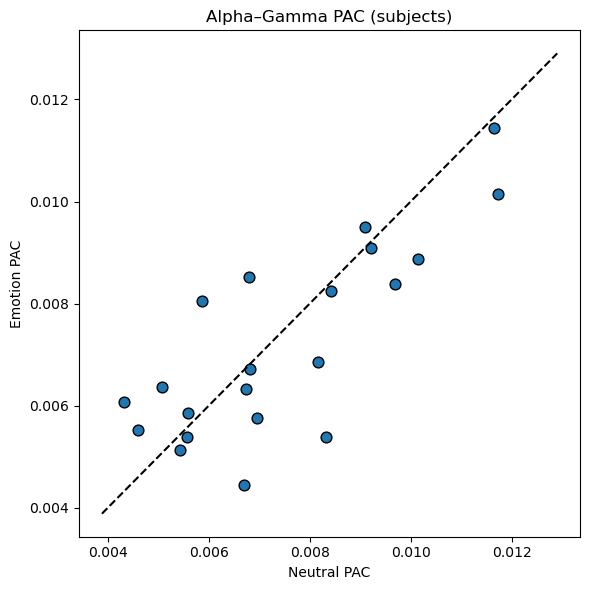

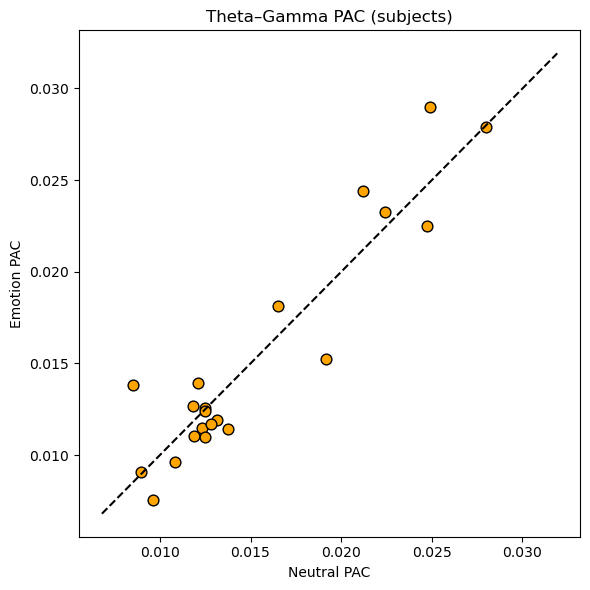

In [26]:
#plots <3

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df.ag_neutral, df.ag_emotion, s=60, edgecolor="k")
lim = [df[["ag_neutral","ag_emotion"]].min().min()*0.9,
       df[["ag_neutral","ag_emotion"]].max().max()*1.1]
plt.plot(lim, lim, "k--")
plt.xlabel("Neutral PAC")
plt.ylabel("Emotion PAC")
plt.title("Alpha–Gamma PAC (subjects)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df.tg_neutral, df.tg_emotion, s=60, edgecolor="k", color="orange")
lim = [df[["tg_neutral","tg_emotion"]].min().min()*0.9,
       df[["tg_neutral","tg_emotion"]].max().max()*1.1]
plt.plot(lim, lim, "k--")
plt.xlabel("Neutral PAC")
plt.ylabel("Emotion PAC")
plt.title("Theta–Gamma PAC (subjects)")
plt.tight_layout()
plt.show()


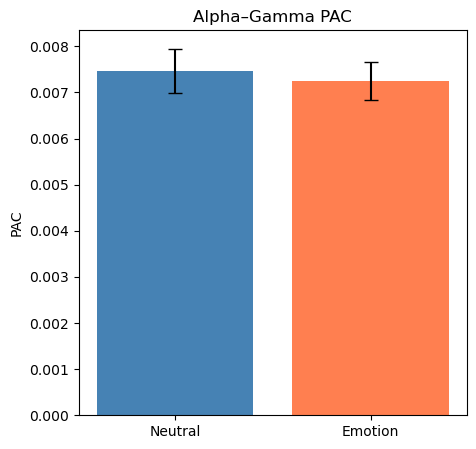

In [27]:
import numpy as np

means = [df.ag_neutral.mean(), df.ag_emotion.mean()]
sems  = [df.ag_neutral.sem(), df.ag_emotion.sem()]

plt.figure(figsize=(5,5))
plt.bar(["Neutral","Emotion"], means, yerr=sems, 
        color=["steelblue","coral"], capsize=5)
plt.title("Alpha–Gamma PAC")
plt.ylabel("PAC")
plt.show()


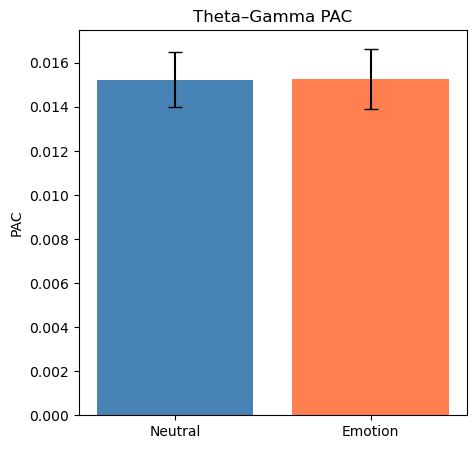

In [33]:
means_t = [df.tg_neutral.mean(), df.tg_emotion.mean()]
sems_t  = [df.tg_neutral.sem(), df.tg_emotion.sem()]

plt.figure(figsize=(5,5))
plt.bar(["Neutral","Emotion"], means_t, yerr=sems_t, 
        color=["steelblue","coral"], capsize=5)
plt.title("Theta–Gamma PAC")
plt.ylabel("PAC")
plt.show()

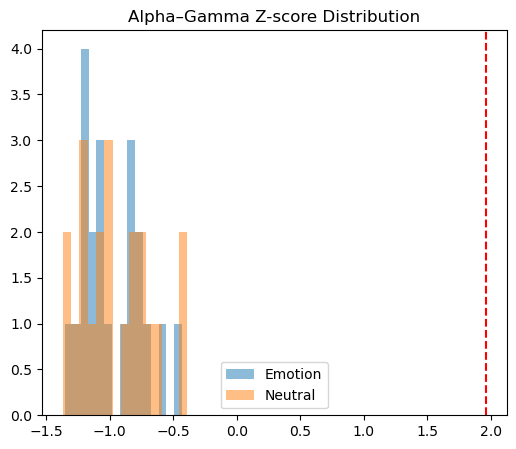

In [28]:
plt.figure(figsize=(6,5))
plt.hist(df.z_ag_emotion, bins=15, alpha=0.5, label="Emotion")
plt.hist(df.z_ag_neutral, bins=15, alpha=0.5, label="Neutral")
plt.axvline(1.96, color="red", linestyle="--")
plt.title("Alpha–Gamma Z-score Distribution")
plt.legend()
plt.show()


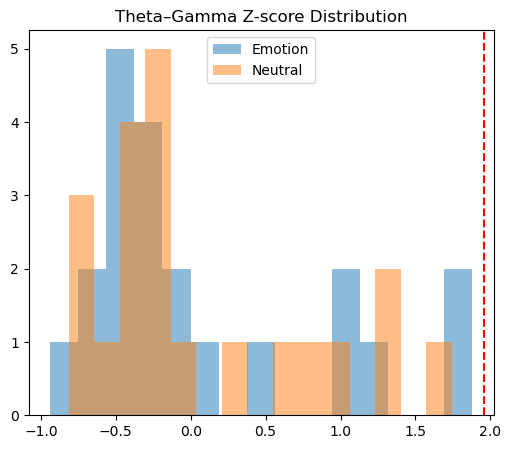

In [32]:
plt.figure(figsize=(6,5))
plt.hist(df.z_tg_emotion, bins=15, alpha=0.5, label="Emotion")
plt.hist(df.z_tg_neutral, bins=15, alpha=0.5, label="Neutral")
plt.axvline(1.96, color="red", linestyle="--")
plt.title("Theta–Gamma Z-score Distribution")
plt.legend()
plt.show()

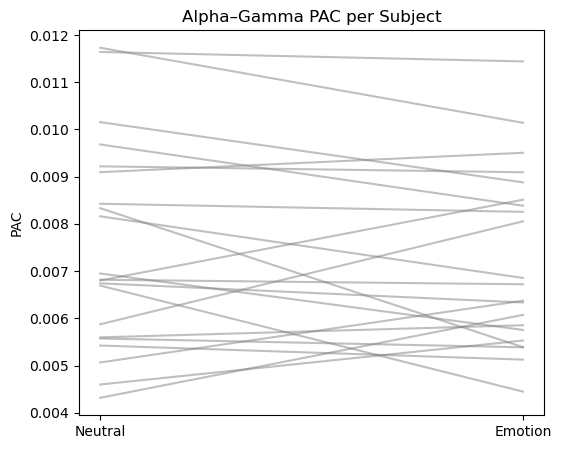

In [29]:
plt.figure(figsize=(6,5))
for _, row in df.iterrows():
    plt.plot(["Neutral","Emotion"], 
             [row.ag_neutral, row.ag_emotion],
             color="gray", alpha=0.5)
plt.title("Alpha–Gamma PAC per Subject")
plt.ylabel("PAC")
plt.show()


In [30]:
print(df.sort_values("ag_emotion", ascending=False).head())
print(df.sort_values("tg_emotion", ascending=False).head())


   subject  ag_emotion  ag_neutral  tg_emotion  tg_neutral  z_ag_emotion  \
18      21    0.011440    0.011640    0.027876    0.027970     -0.430891   
8       10    0.010141    0.011729    0.029014    0.024919     -0.601789   
10      13    0.009506    0.009096    0.024383    0.021206     -0.685292   
7       09    0.009094    0.009219    0.022477    0.024715     -0.739529   
1       02    0.008880    0.010155    0.012675    0.011818     -0.767700   

    z_ag_neutral  z_tg_emotion  z_tg_neutral   ag_diff   tg_diff  
18     -0.404581      1.730806      1.743167 -0.000200 -0.000094  
8      -0.392917      1.880569      1.341929 -0.001588  0.004095  
10     -0.739289      1.271363      0.853485  0.000411  0.003177  
7      -0.723041      1.020765      1.315104 -0.000125 -0.002238  
1      -0.600006     -0.268452     -0.381192 -0.001275  0.000857  
   subject  ag_emotion  ag_neutral  tg_emotion  tg_neutral  z_ag_emotion  \
8       10    0.010141    0.011729    0.029014    0.024919     -0

In [31]:
df.to_csv("PIPELINE1_pac_results_final.csv", index=False)

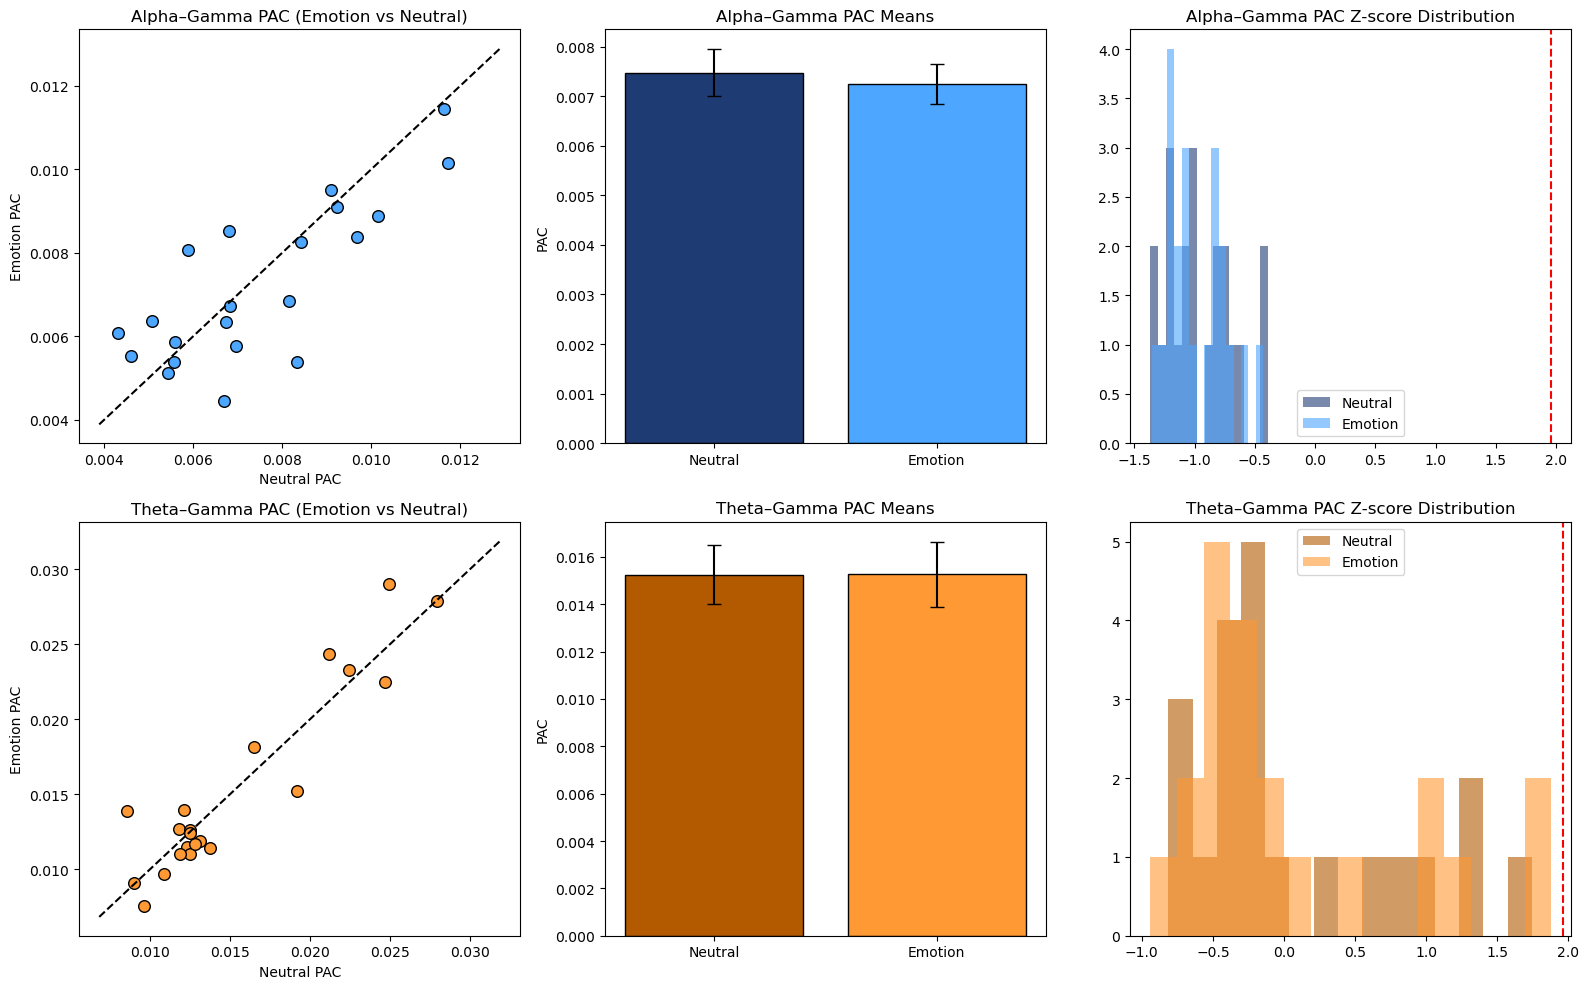

In [39]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# ---------------------------------------------------------
# STRONGLY DIFFERENTIATED COLORS
alpha_neutral = "#1f3b73"     # dark navy blue
alpha_emotion = "#4da6ff"     # bright sky blue

theta_neutral = "#b35900"     # dark burnt orange
theta_emotion = "#ff9933"     # bright vivid orange

# ---------------------- 1. Scatter AG ---------------------
ax = axes[0, 0]
ax.scatter(df.ag_neutral, df.ag_emotion, s=70, edgecolor="black",
           facecolor=alpha_emotion)  
lim = [df[["ag_neutral","ag_emotion"]].min().min()*0.9,
       df[["ag_neutral","ag_emotion"]].max().max()*1.1]
ax.plot(lim, lim, "k--")
ax.set_title("Alpha–Gamma PAC (Emotion vs Neutral)")
ax.set_xlabel("Neutral PAC")
ax.set_ylabel("Emotion PAC")

# ---------------------- 2. Bar AG -------------------------
ax = axes[0, 1]
means_ag = [df.ag_neutral.mean(), df.ag_emotion.mean()]
sems_ag  = [df.ag_neutral.sem(), df.ag_emotion.sem()]
ax.bar(["Neutral","Emotion"], means_ag, yerr=sems_ag,
       color=[alpha_neutral, alpha_emotion], capsize=5, edgecolor="black")
ax.set_title("Alpha–Gamma PAC Means")
ax.set_ylabel("PAC")

# ---------------------- 3. Z-hist AG ----------------------
ax = axes[0, 2]
ax.hist(df.z_ag_neutral, bins=15, alpha=0.6, label="Neutral", color=alpha_neutral)
ax.hist(df.z_ag_emotion, bins=15, alpha=0.6, label="Emotion", color=alpha_emotion)
ax.axvline(1.96, color="red", linestyle="--")
ax.set_title("Alpha–Gamma PAC Z-score Distribution")
ax.legend()

# ---------------------- 4. Scatter TG ---------------------
ax = axes[1, 0]
ax.scatter(df.tg_neutral, df.tg_emotion, s=70, edgecolor="black",
           facecolor=theta_emotion)
lim = [df[["tg_neutral","tg_emotion"]].min().min()*0.9,
       df[["tg_neutral","tg_emotion"]].max().max()*1.1]
ax.plot(lim, lim, "k--")
ax.set_title("Theta–Gamma PAC (Emotion vs Neutral)")
ax.set_xlabel("Neutral PAC")
ax.set_ylabel("Emotion PAC")

# ---------------------- 5. Bar TG -------------------------
ax = axes[1, 1]
means_tg = [df.tg_neutral.mean(), df.tg_emotion.mean()]
sems_tg  = [df.tg_neutral.sem(), df.tg_emotion.sem()]
ax.bar(["Neutral","Emotion"], means_tg, yerr=sems_tg,
       color=[theta_neutral, theta_emotion], capsize=5, edgecolor="black")
ax.set_title("Theta–Gamma PAC Means")
ax.set_ylabel("PAC")

# ---------------------- 6. Z-hist TG ----------------------
ax = axes[1, 2]
ax.hist(df.z_tg_neutral, bins=15, alpha=0.6, label="Neutral", color=theta_neutral)
ax.hist(df.z_tg_emotion, bins=15, alpha=0.6, label="Emotion", color=theta_emotion)
ax.axvline(1.96, color="red", linestyle="--")
ax.set_title("Theta–Gamma PAC Z-score Distribution")
ax.legend()

plt.tight_layout()
plt.savefig("pac_plots_new")
plt.show()
